Setup the environment here

In [3]:
import pandas as pd

Filter the test file for the negative reviews in the local files area

In [6]:
df = pd.read_csv("amazon_review_polarity_csv/test.csv", names = ["polarity", "title", "review"])
df = df[df.polarity == 1]

Load the output into S3 in prep for comprehend processing

In [9]:
test = df.drop(columns = ["title", "polarity"])
test.to_csv("test_file_10k_sample_only_content.csv", encoding="utf-8")
test = test.sample(10000)

Used the following to upload via terminal:
aws s3 cp test_file_10k_sample_only_content.csv s3://nlp-jsears-output/test_file_10k_sample_only_content.csv

Process using comprehend

In [ ]:
import json
import csv
from bson import json_util
import boto3

comprehend = boto3.client('comprehend')
input_s3_url = "s3://nlp-jsears-output/test_file_10k_sample_only_content.csv"
input_doc_format = "ONE_DOC_PER_LINE"
#output_s3_url = "s3://nlp-kc-learning/js-output/"
output_s3_url = "s3://nlp-jsears-output/output"
#data_access_role_arn = "arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824"
data_access_role_arn = "arn:aws:iam::023375022819:role/service-role/AmazonComprehendServiceRole-mark"
number_of_topics = 10

input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}
output_data_config = {"S3Uri": output_s3_url}

start_topics_detection_job_result = \
    comprehend.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                          JobName="jsears_test_topics_1",
                                          InputDataConfig=input_data_config,
                                          OutputDataConfig=output_data_config,
                                          DataAccessRoleArn=data_access_role_arn)

print('start_topics_detection_job_result: ' + json.dumps(start_topics_detection_job_result))
 
job_id = start_topics_detection_job_result["JobId"]
 
print('job_id: ' + job_id)
 
describe_topics_detection_job_result = comprehend.describe_topics_detection_job(JobId=job_id)
 
print('describe_topics_detection_job_result: ' + json.dumps(describe_topics_detection_job_result, default=json_util.default))

list_topics_detection_jobs_result = comprehend.list_topics_detection_jobs()
 
print('list_topics_detection_jobs_result: ' + json.dumps(list_topics_detection_jobs_result, default=json_util.default))

In [12]:
!aws s3 cp s3://nlp-jsears-output/output/023375022819-TOPICS-f2a13706eac6c79237e4f3c52f4cda95/output/output.tar.gz ./output2.tar.gz

download: s3://nlp-jsears-output/output/023375022819-TOPICS-f2a13706eac6c79237e4f3c52f4cda95/output/output.tar.gz to ./output2.tar.gz


In [15]:
!tar -xzvf output2.tar.gz -C ./data2

doc-topics.csv
topic-terms.csv


In [16]:
!head ./data2/doc-topics.csv

docname,topic,proportion
test_file_10k_sample_only_content.csv:19,001,1.0
test_file_10k_sample_only_content.csv:54,004,1.0
test_file_10k_sample_only_content.csv:89,000,1.0
test_file_10k_sample_only_content.csv:124,008,1.0
test_file_10k_sample_only_content.csv:159,004,1.0
test_file_10k_sample_only_content.csv:194,001,1.0
test_file_10k_sample_only_content.csv:229,005,1.0
test_file_10k_sample_only_content.csv:264,002,1.0
test_file_10k_sample_only_content.csv:299,000,1.0


In [17]:
!head ./data2/topic-terms.csv

topic,term,weight
000,book,0.07113573
000,read,0.03092164
000,story,0.013365041
000,write,0.0128427185
000,character,0.0102796685
000,author,0.008050485
000,interest,0.007084855
000,page,0.0063803624
000,find,0.009354592


In [18]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 28.0MB/s 
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


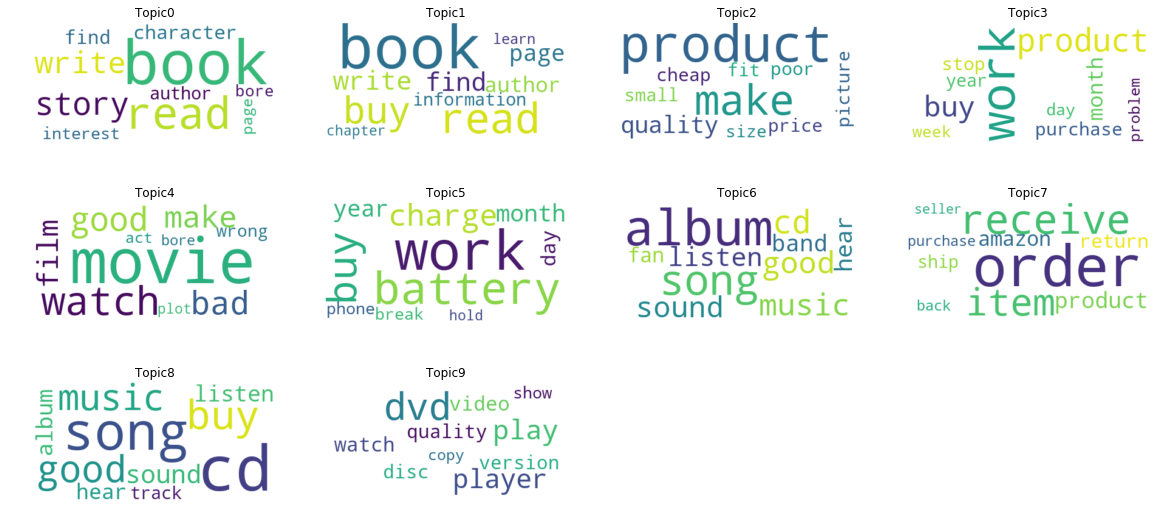

In [83]:
#from word_cloud.word_cloud_generator import WordCloud 
#from IPython.core.display import HTML 
import wordcloud as wc
import pandas as pd
import matplotlib.pyplot as plt

num_topics = 10
n_col = 4
counter = 0
limit = 20

df = pd.read_csv("data2/topic-terms.csv", names = ["topic", "term", "weight"])

#word_to_id = dict()
#for i, v in enumerate(vocab_list):
#    word_to_id[v] = i

plt.figure(figsize=(20,16))
for ind in range(num_topics):
    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    #pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()
    
    word_freq = dict()
    df1 = df[df['topic'] == "00"+str(ind)].drop(columns=['topic'])
    #print(df1)
    for t in df1.itertuples():
        #print(t.term)
        word_freq[t.term]=float(t.weight)
    
    #print(word_freq)

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1
 
